In [2]:
#importing packages

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy.stats as stats
import itertools as it
import math 
import pandas as pd
import seaborn as sns
import pyswarms as ps




In [3]:
##define the fixed parameters
hatchability = 0.98  #if hatchability is density (egg or adult) depedent, then define it in the pre-adult-module or the adult-module functions 
x1 = 2.5  #parameter in finding the mean larval size
x2 = 1  #parameter in finding the mean larval size 
x3 = 0.009 #parameter in finding the mean larval size 
sigma_size = 0.45  #parameter in assigning larval sizes by drawing from a normal distribution
mc = 1.1 #critical size cut off of the larval stage for successful pupation (= 1.1 (JB) and 1 (FEJ))
x4 = 1.0  #parameter in finding the adult sizes
female_proportion = 0.5 #assign sex to the adutls 
x5 = 85 #parameter in finding fecundity
x6 = 2  #parameter in finding fecundity

'''
sen_adsize = 1.7 #parameter related to sensivity of fecundity to adult size
sen_adden = 0.17 #parameter related to sensivity of fecundity to adult denisity
f = 0#migration rate

'''
#pre-defning all parameters requriref for adult module and pre-adult module, as well as migration. These parameters are re-defined according to the simulatuion wer taking 

'\nsen_adsize = 1.7 #parameter related to sensivity of fecundity to adult size\nsen_adden = 0.17 #parameter related to sensivity of fecundity to adult denisity\nf = 0#migration rate\n\n'

In [4]:
##Pre-Adult-Module
#food = larval food amt; 1.76 (LL and LH), 2.56 (HL and HH) 


def Pre_Adult_Module(numegg,food):
    """  
This function takes the number of eggs in gen t and larval food amount as input and returns the number of adults in gen t and their size distribution as output.

Args: 
    numegg (int): number of eggs in generation t
    food (float): larval food amount in ml

Returns:
    numadult (int): number of adults in generation t
    size_adult_arr (array): size distribution of adults in generation t
"""
    numlarva = int(hatchability*numegg)
    mean_size = x1*(1-1/(x2+np.exp(-x3*numlarva+food)))
    size_larva_arr = abs(np.random.normal(mean_size, sigma_size, numlarva))
    numadult = (size_larva_arr>=mc).sum()
    size_adult_arr = x4*size_larva_arr[size_larva_arr>=mc]
    return numadult, size_adult_arr




In [5]:
##Demographic-Stochasticity

def Demo_Stoch(numadult, size_adult_arr):
    """  
This function takes the number of adults in gen t and their size distribution, if their number is less than 8 then it is reduced to 0 by 50 % chance

Args: 
    numadult (int): number of adults in generation t before demographic stochasticity
    size_adult_arr (array): size distribution of adults in generation t before demographic stochasticity

Returns:
    numadult (int): number of adults in generation t after demographic stochasticity
    size_adult_arr (array): size distribution of adults in generation t after demographic stochasticity
    """
    if numadult < 8:
        numadult = np.random.binomial(size=1, n=1, p=0.5)*numadult # numadult either remains the same or is reduced to 0
        numadult = numadult[0] 
        if numadult == 0:
            size_adult_arr = np.array([])
    return numadult, size_adult_arr



#demographic stoch. is not implemneted in metapop case, because stochasiticity is quite low


In [6]:
##Female_Size

def Female_Size(size_adult_arr):
    """  
This function takes size_adult_arr as input and returns female_size_arr as output.

Args: 
    size_adult_arr (array): size distribution of adults in generation t

Returns:
    size_female_arr (array): size distribution of only females in generation t
"""
    numadult = np.shape(size_adult_arr)[0]
    adult_sex_arr = np.random.binomial(size=numadult, n=1, p=female_proportion) # 1 is a female and 0 a male
    size_female_arr = size_adult_arr[adult_sex_arr == 1]
    return size_female_arr

In [7]:
##Metapopulation_Reset

def Metapopulation_Reset(numadult1,numadult2,size_female_arr1,size_female_arr2):
    """
This function takes numadult and size_female_arr of both patches post-demo-stoch as inputs and returns numadult and size_female_arr of both patches after metapopulation reset as output.

Args: 
    numadult1 (int): number of adults in patch 1 in generation t post-demo-stoch pre-metapopulation-reset
    numadult2 (int): number of adults in patch 2 in generation t post-demo-stoch pre-metapopulation-reset   
    size_female_arr1 (array): size distribution of females in patch 1 in generation t post-demo-stoch pre-metapopulation-reset
    size_female_arr2 (array): size distribution of females in patch 2 in generation t post-demo-stoch pre-metapopulation-reset

Returns:
    numadult1 (int): number of adults in patch 1 in generation t post-metapopulation-reset
    numadult2 (int): number of adults in patch 2 in generation t post-metapopulation-reset  
    size_female_arr1 (array): size distribution of females in patch 1 in generation t post-metapopulation-reset
    size_female_arr2 (array): size distribution of females in patch 2 in generation t post-metapopulation-reset
"""
    if numadult1 == 0 and numadult2 == 0:
        numadult1 = 8 #resetting the population to 4 males and 4 females
        numadult2 = 8
        size_female_arr1 = 2*mc*np.ones(int(numadult1/2))
        size_female_arr2 = 2*mc*np.ones(int(numadult2/2))

    return numadult1,numadult2,size_female_arr1,size_female_arr2


#there is metapopulation reset
#num_adult_1 and num_adult_2 are patch 1 and patch 2 number of adults respectvely. Reset happens only when both go to zero. then both are reset with 8 and 8.

In [8]:
##Migration

def Migration_with_f(numadult1,numadult2,size_female_arr1,size_female_arr2, f_val):
    """  
This function takes numadult and size_female_arr of both patches as inputs and returns numadult and size_female_arr of both patches post migration as output.

Args: 
    numadult1 (int): number of adults in patch 1 in generation t pre-migration
    numadult2 (int): number of adults in patch 2 in generation t pre-migration    
    size_female_arr1 (array): size distribution of females in patch 1 in generation t pre-migration
    size_female_arr2 (array): size distribution of females in patch 2 in generation t pre-migration

Returns:
    numadult1 (int): number of adults in patch 1 in generation t post-migration
    numadult2 (int): number of adults in patch 2 in generation t post-migration    
    size_female_arr1 (array): size distribution of females in patch 1 in generation t post-migration
    size_female_arr2 (array): size distribution of females in patch 2 in generation t post-migration
"""
    mig_female_12 = size_female_arr1[(len(size_female_arr1)-round(f_val*numadult1/2)):]
    #print(mig_female_12)
    mig_female_21 = size_female_arr2[(len(size_female_arr2)-round(f_val*numadult2/2)):]
    #print(mig_female_21)
    size_female_arr1 = np.concatenate((size_female_arr1[0:(len(size_female_arr1)-round(f*numadult1/2))],mig_female_21))
    #print(size_female_arr1)
    size_female_arr2 = np.concatenate((size_female_arr2[0:(len(size_female_arr2)-round(f*numadult2/2))],mig_female_12))
    #print(size_female_arr2)
    numadult1_update = numadult1 - round(f_val*numadult1/2) + round(f_val*numadult2/2)
    numadult2_update = numadult2 - round(f_val*numadult2/2) + round(f_val*numadult1/2)
    numadult1 = numadult1_update
    numadult2 = numadult2_update
    return numadult1,numadult2,size_female_arr1,size_female_arr2

#num adult 1, size_female_arr 1 -> females in patch 1 and their sizes. Size female arr 2 -> females in patch 2 arr 2

In [9]:
#Migration fucntio that explicity takes f as input

##Migration

def Migration(numadult1,numadult2,size_female_arr1,size_female_arr2):
    """  
This function takes numadult and size_female_arr of both patches as inputs and returns numadult and size_female_arr of both patches post migration as output.

Args: 
    numadult1 (int): number of adults in patch 1 in generation t pre-migration
    numadult2 (int): number of adults in patch 2 in generation t pre-migration    
    size_female_arr1 (array): size distribution of females in patch 1 in generation t pre-migration
    size_female_arr2 (array): size distribution of females in patch 2 in generation t pre-migration

Returns:
    numadult1 (int): number of adults in patch 1 in generation t post-migration
    numadult2 (int): number of adults in patch 2 in generation t post-migration    
    size_female_arr1 (array): size distribution of females in patch 1 in generation t post-migration
    size_female_arr2 (array): size distribution of females in patch 2 in generation t post-migration
"""
    mig_female_12 = size_female_arr1[(len(size_female_arr1)-round(f*numadult1/2)):]
    #print(mig_female_12)
    mig_female_21 = size_female_arr2[(len(size_female_arr2)-round(f*numadult2/2)):]
    #print(mig_female_21)
    size_female_arr1 = np.concatenate((size_female_arr1[0:(len(size_female_arr1)-round(f*numadult1/2))],mig_female_21))
    #print(size_female_arr1)
    size_female_arr2 = np.concatenate((size_female_arr2[0:(len(size_female_arr2)-round(f*numadult2/2))],mig_female_12))
    #print(size_female_arr2)
    numadult1_update = numadult1 - round(f*numadult1/2) + round(f*numadult2/2)
    numadult2_update = numadult2 - round(f*numadult2/2) + round(f*numadult1/2)
    numadult1 = numadult1_update
    numadult2 = numadult2_update
    return numadult1,numadult2,size_female_arr1,size_female_arr2

#num adult 1, size_female_arr 1 -> females in patch 1 and their sizes. Size female arr 2 -> females in patch 2 arr 2

In [10]:
##Adult-Module
#adnut = #adult food nutrition quality; 1 (LL and HL), 1.29 (HH) and 1.49 (LH)

def Adult_Module(numadult, size_female_arr,adnut):
    """  
This function takes the number of adults in gen t, the female size distribution and the nutrition quality of adult food as inputs and returns the number of eggs in gen t+1 as output.

Args: 
    numadult (int): number of adults in generation t
    size_female_arr (array): size distribution of females in generation t
    adnut (float): adult food nutrition quality

Returns:
    numegg (int): number of eggs in generation t+1
"""
    addens_ind_fec_arr = adnut*x5*np.log(x6+sen_adsize*size_female_arr)
    addens_eff = 1/(1+sen_adden*numadult)
    fecundity_arr = addens_eff*addens_ind_fec_arr
    fecundity_arr = fecundity_arr.astype(int)
    numegg = fecundity_arr.sum()
    return numegg


In [11]:
##Adult-Module_which_explicitly takes in sen_adden and sen_adsize as inputs
#adnut = #adult food nutrition quality; 1 (LL and HL), 1.29 (HH) and 1.49 (LH)

def Adult_Module_with_sens_inputs(numadult, size_female_arr,adnut, sen_adden_val, sen_adsize_val):
    """  
This function takes the number of adults in gen t, the female size distribution and the nutrition quality of adult food as inputs and returns the number of eggs in gen t+1 as output.

Args: 
    numadult (int): number of adults in generation t
    size_female_arr (array): size distribution of females in generation t
    adnut (float): adult food nutrition quality

Returns:
    numegg (int): number of eggs in generation t+1
"""
    addens_ind_fec_arr = adnut*x5*np.log(x6+sen_adsize_val*size_female_arr)
    addens_eff = 1/(1+sen_adden_val*numadult)
    fecundity_arr = addens_eff*addens_ind_fec_arr
    fecundity_arr = fecundity_arr.astype(int)
    numegg = fecundity_arr.sum()
    return numegg


In [12]:
##Metapop_Simulation

def Metapop_Simulation(numegg1_start,food1,adnut1,numegg2_start,food2,adnut2,generations,replicates):



    """  
This function takes the number of eggs in gen 1, food amount provided to the larvae in each of the successive gens,
the adult food nutrition quality in each of the successive gens for each subpopulation, 
number of generations for which each simulation will be run and the number of replicate simulations 
that will be run as inputs and returns a matrix of adult population sizes for each generation 
(each column is a replicate simulation and each row is a generation), a matrix of number of 
eggs in each generation and a matrix of extinctions for each replicate for both the subpopulations

Args: 
    numegg1_start (int): number of eggs in generation 1 for patch 1
    food1 (float): larval food amount in ml for patch 1
    adnut1 (float): adult food nutrition quality for patch 1
    numegg2_start (int): number of eggs in generation 1 for patch 2
    food2 (float): larval food amount in ml for patch 2
    adnut2 (float): adult food nutrition quality for patch 2
    generations (int): number of generations for which each simulation will be run
    replicates (int): number of replicate simulations that will be run

Returns:
    numadult_matrix1 (array): array of adult population sizes for each generation 
    (each column is a replicate simulation and each row is a generation) for patch 1
    numegg_matrix1 (array): array of number of eggs in each generation for patch 1
    extinctions_matrix1 (array): array of extinctions for each generation {1 if extinction happens and 0 otherwise} 
    (each column is a replicate simulation and each row is a generation) for patch 1
    numadult_matrix2 (array): array of adult population sizes for each generation for patch 2
    numegg_matrix2 (array): array of number of eggs in each generation for patch 2
    extinctions_matrix2 (array): array of extinctions for each generation for patch 2
"""
    numadult_matrix1 = np.zeros((generations,replicates)) #array to store the number of adults per generation (patch 1 matrix -reach cokun s a repicae 
    numegg_matrix1 = np.zeros((generations,replicates)) #array to store the number of eggs per generation         
    extinctions_matrix1 = np.zeros((generations,replicates)) #array denoting if extinction happened in any given gen 
    numadult_matrix2 = np.zeros((generations,replicates))  #patch 2 matrix is simula r
    numegg_matrix2 = np.zeros((generations,replicates))
    extinctions_matrix2 = np.zeros((generations,replicates))

    print(sen_adden)

    for i in range(replicates):
        # 1st generation, we start with numegg1_start and numegg2_start eggs respectively   
        numegg1 = numegg1_start  
        numegg2 = numegg2_start
        numegg_matrix1[0,i] = numegg1 
        numegg_matrix2[0,i] = numegg2
        numadult1, size_adult_arr1 = Pre_Adult_Module(numegg1,food1)
        #print(numadult1)
        numadult2, size_adult_arr2 = Pre_Adult_Module(numegg2,food2)
        #print(numadult2)
        numadult1,size_adult_arr1 = Demo_Stoch(numadult1,size_adult_arr1) #Where to put demo stoch?
        numadult2,size_adult_arr2  = Demo_Stoch(numadult2,size_adult_arr2) 
        #print(numadult1,numadult2)
        size_female_arr1 = Female_Size(size_adult_arr1)   
        #print(size_female_arr1)
        size_female_arr2 = Female_Size(size_adult_arr2)
        #print(size_adult_arr2)
        if numadult1 == 0 and numadult2 > 0:
            extinctions_matrix1[0,i] = 1
            numadult_matrix1[0,i] = numadult1
            numadult_matrix2[0,i] = numadult2
        elif numadult1 > 0 and numadult2 == 0:
            extinctions_matrix2[0,i] = 1
            numadult_matrix1[0,i] = numadult1
            numadult_matrix2[0,i] = numadult2
        elif numadult1 == 0 and numadult2 == 0: 
            numadult_matrix1[0,i] = 8 
            numadult_matrix2[0,i] = 8
            extinctions_matrix1[0,i] = 1
            extinctions_matrix2[0,i] = 1 
        else:
            numadult_matrix1[0,i] = numadult1
            numadult_matrix2[0,i] = numadult2
        numadult1,numadult2,size_female_arr1,size_female_arr2 = Metapopulation_Reset(numadult1,numadult2,size_female_arr1,size_female_arr2)
        #print(numadult1,numadult2)
        numadult1,numadult2,size_female_arr1,size_female_arr2 = Migration(numadult1,numadult2,size_female_arr1,size_female_arr2)

        for j in range(1,generations):
            numegg1 = Adult_Module(numadult1,size_female_arr1,adnut1)
            numegg2 = Adult_Module(numadult2,size_female_arr2,adnut2)
            numegg_matrix1[j,i] = numegg1
            numegg_matrix2[j,i] = numegg2
            numadult1, size_adult_arr1 = Pre_Adult_Module(numegg1,food1)
            numadult2, size_adult_arr2 = Pre_Adult_Module(numegg2,food2)
            numadult1,size_adult_arr1 = Demo_Stoch(numadult1,size_adult_arr1)
            numadult2,size_adult_arr2 = Demo_Stoch(numadult2,size_adult_arr2)
            size_female_arr1 = Female_Size(size_adult_arr1)
            size_female_arr2 = Female_Size(size_adult_arr2)
            if numadult1 == 0 and numadult2 > 0:
                extinctions_matrix1[j,i] = 1
                numadult_matrix1[j,i] = numadult1
                numadult_matrix2[j,i] = numadult2
            elif numadult1 > 0 and numadult2 == 0:
                extinctions_matrix2[j,i] = 1
                numadult_matrix1[j,i] = numadult1
                numadult_matrix2[j,i] = numadult2
            elif numadult1 == 0 and numadult2 == 0: 
                numadult_matrix1[j,i] = 8
                numadult_matrix2[j,i] = 8
                extinctions_matrix1[j,i] = 1
                extinctions_matrix2[j,i] = 1 
            else:
                numadult_matrix1[j,i] = numadult1
                numadult_matrix2[j,i] = numadult2
            numadult1,numadult2,size_female_arr1,size_female_arr2 = Metapopulation_Reset(numadult1,numadult2,size_female_arr1,size_female_arr2)
            numadult1,numadult2,size_female_arr1,size_female_arr2 = Migration(numadult1,numadult2,size_female_arr1,size_female_arr2)
    return numadult_matrix1,numegg_matrix1,extinctions_matrix1,numadult_matrix2,numegg_matrix2,extinctions_matrix2

In [13]:
##Metapop_Simulation function food, adnut, sen_adden, sen_adsize, f as inputs

def Metapop_Simulation_all_vars(numegg1_start,food1,adnut1,numegg2_start,food2,adnut2,generations,replicates, sen_adden_val, sen_adsize_val, f_val):



    """  
This function takes the number of eggs in gen 1, food amount provided to the larvae in each of the successive gens,
the adult food nutrition quality in each of the successive gens for each subpopulation, 
number of generations for which each simulation will be run and the number of replicate simulations 
that will be run as inputs and returns a matrix of adult population sizes for each generation 
(each column is a replicate simulation and each row is a generation), a matrix of number of 
eggs in each generation and a matrix of extinctions for each replicate for both the subpopulations

Args: 
    numegg1_start (int): number of eggs in generation 1 for patch 1
    food1 (float): larval food amount in ml for patch 1
    adnut1 (float): adult food nutrition quality for patch 1
    numegg2_start (int): number of eggs in generation 1 for patch 2
    food2 (float): larval food amount in ml for patch 2
    adnut2 (float): adult food nutrition quality for patch 2
    generations (int): number of generations for which each simulation will be run
    replicates (int): number of replicate simulations that will be run

Returns:
    numadult_matrix1 (array): array of adult population sizes for each generation 
    (each column is a replicate simulation and each row is a generation) for patch 1
    numegg_matrix1 (array): array of number of eggs in each generation for patch 1
    extinctions_matrix1 (array): array of extinctions for each generation {1 if extinction happens and 0 otherwise} 
    (each column is a replicate simulation and each row is a generation) for patch 1
    numadult_matrix2 (array): array of adult population sizes for each generation for patch 2
    numegg_matrix2 (array): array of number of eggs in each generation for patch 2
    extinctions_matrix2 (array): array of extinctions for each generation for patch 2
"""
    numadult_matrix1 = np.zeros((generations,replicates)) #array to store the number of adults per generation (patch 1 matrix -reach cokun s a repicae 
    numegg_matrix1 = np.zeros((generations,replicates)) #array to store the number of eggs per generation         
    extinctions_matrix1 = np.zeros((generations,replicates)) #array denoting if extinction happened in any given gen 
    numadult_matrix2 = np.zeros((generations,replicates))  #patch 2 matrix is simula r
    numegg_matrix2 = np.zeros((generations,replicates))
    extinctions_matrix2 = np.zeros((generations,replicates))

    for i in range(replicates):
        # 1st generation, we start with numegg1_start and numegg2_start eggs respectively   
        numegg1 = numegg1_start  
        numegg2 = numegg2_start
        numegg_matrix1[0,i] = numegg1 
        numegg_matrix2[0,i] = numegg2
        numadult1, size_adult_arr1 = Pre_Adult_Module(numegg1,food1)
        #print(numadult1)
        numadult2, size_adult_arr2 = Pre_Adult_Module(numegg2,food2)
        #print(numadult2)
        numadult1,size_adult_arr1 = Demo_Stoch(numadult1,size_adult_arr1) #Where to put demo stoch?
        numadult2,size_adult_arr2  = Demo_Stoch(numadult2,size_adult_arr2) 
        #print(numadult1,numadult2)
        size_female_arr1 = Female_Size(size_adult_arr1)   
        #print(size_female_arr1)
        size_female_arr2 = Female_Size(size_adult_arr2)
        #print(size_adult_arr2)
        if numadult1 == 0 and numadult2 > 0:
            extinctions_matrix1[0,i] = 1
            numadult_matrix1[0,i] = numadult1
            numadult_matrix2[0,i] = numadult2
        elif numadult1 > 0 and numadult2 == 0:
            extinctions_matrix2[0,i] = 1
            numadult_matrix1[0,i] = numadult1
            numadult_matrix2[0,i] = numadult2
        elif numadult1 == 0 and numadult2 == 0: 
            numadult_matrix1[0,i] = 8 
            numadult_matrix2[0,i] = 8
            extinctions_matrix1[0,i] = 1
            extinctions_matrix2[0,i] = 1 
        else:
            numadult_matrix1[0,i] = numadult1
            numadult_matrix2[0,i] = numadult2
        numadult1,numadult2,size_female_arr1,size_female_arr2 = Metapopulation_Reset(numadult1,numadult2,size_female_arr1,size_female_arr2)
        #print(numadult1,numadult2)
        numadult1,numadult2,size_female_arr1,size_female_arr2 = Migration_with_f(numadult1,numadult2,size_female_arr1,size_female_arr2, f_val)

        for j in range(1,generations):
            numegg1 = Adult_Module_with_sens_inputs(numadult1,size_female_arr1,adnut1, sen_adden_val, sen_adsize_val)
            numegg2 = Adult_Module_with_sens_inputs(numadult2,size_female_arr2,adnut2, sen_adden_val, sen_adsize_val)
            numegg_matrix1[j,i] = numegg1
            numegg_matrix2[j,i] = numegg2
            numadult1, size_adult_arr1 = Pre_Adult_Module(numegg1,food1)
            numadult2, size_adult_arr2 = Pre_Adult_Module(numegg2,food2)
            numadult1,size_adult_arr1 = Demo_Stoch(numadult1,size_adult_arr1)
            numadult2,size_adult_arr2 = Demo_Stoch(numadult2,size_adult_arr2)
            size_female_arr1 = Female_Size(size_adult_arr1)
            size_female_arr2 = Female_Size(size_adult_arr2)
            if numadult1 == 0 and numadult2 > 0:
                extinctions_matrix1[j,i] = 1
                numadult_matrix1[j,i] = numadult1
                numadult_matrix2[j,i] = numadult2
            elif numadult1 > 0 and numadult2 == 0:
                extinctions_matrix2[j,i] = 1
                numadult_matrix1[j,i] = numadult1
                numadult_matrix2[j,i] = numadult2
            elif numadult1 == 0 and numadult2 == 0: 
                numadult_matrix1[j,i] = 8
                numadult_matrix2[j,i] = 8
                extinctions_matrix1[j,i] = 1
                extinctions_matrix2[j,i] = 1 
            else:
                numadult_matrix1[j,i] = numadult1
                numadult_matrix2[j,i] = numadult2
            numadult1,numadult2,size_female_arr1,size_female_arr2 = Metapopulation_Reset(numadult1,numadult2,size_female_arr1,size_female_arr2)
            numadult1,numadult2,size_female_arr1,size_female_arr2 = Migration_with_f(numadult1,numadult2,size_female_arr1,size_female_arr2, f_val)
    return numadult_matrix1,numegg_matrix1,extinctions_matrix1,numadult_matrix2,numegg_matrix2,extinctions_matrix2

In [14]:
#Metapop_matrices

def Metapop_numegg_matrix(numegg_matrix1,numegg_matrix2):
    """
This function takes the numegg_matrix of both patches as inputs and returns the numegg_matrix of the metapopulation as output.

Args:
    numegg_matrix1 (array): array of number of eggs in each generation (patch 1)
    numegg_matrix2 (array): array of number of eggs in each generation (patch 2)

Returns:
    numadult_matrix (array): array of number of eggs in each generation (metapopulation)
"""
    numegg_matrix = numegg_matrix1 + numegg_matrix2
    return numegg_matrix



def Metapop_numadult_matrix(numadult_matrix1,numadult_matrix2):
    """
This function takes the numadult_matrix of both patches as inputs and returns the numadult_matrix of the metapopulation as output.

Args:
    numadult_matrix1 (array): array of adult population sizes for each generation (patch 1)
    numadult_matrix2 (array): array of adult population sizes for each generation (patch 2)

Returns:
    numadult_matrix (array): array of adult population sizes for each generation (metapopulation)
"""
    numadult_matrix = numadult_matrix1 + numadult_matrix2
    return numadult_matrix


def Metapop_extinctions_matrix(extinctions_matrix1,extinctions_matrix2):
    """
This function takes the extinctions_matrix of both patches as inputs and returns the extinctions_matrix of the metapopulation as output.

Args:
    extinctions_matrix1 (array): array of extinctions for each generation (patch 1)
    extinctions_matrix2 (array): array of extinctions for each generation (patch 2)

Returns:
    extinctions_matrix (array): array of extinctions for each generation (metapopulation)
"""
    extinctions_matrix = extinctions_matrix1 + extinctions_matrix2
    extinctions_matrix = extinctions_matrix/2
    extinctions_matrix[extinctions_matrix < 1] = 0
    return extinctions_matrix

In [15]:
# prob_extinction_n

def prob_extinction_n(extinctions_matrix,n):
    """  
This function takes the extinctions_matrix, and n (number of generations) as input and returns the probability of extinction happening in the first n generations

Args: 
    extinctions_matrix (array): array of extinctions for each generation {1 if extinction happens and 0 otherwise} (each column is a replicate simulation and each row is a generation)
    n (int): first n number of generations   

Returns:
    prob (0 <= float <= 1): rel. freq of replicates in which we did observe an extinction by the nth generation
"""
    if extinctions_matrix.ndim == 1:
        extinctions_matrix = np.expand_dims(extinctions_matrix, axis=1)
    replicates = np.shape(extinctions_matrix)[1]
    col_sum  = extinctions_matrix[0:n,:].sum(axis=0) 
    extinc_repl = (col_sum>=1).sum()
    prob = extinc_repl/replicates
    return prob


In [16]:
# Patch_extinction_freq 

def Patch_extinction_freq(extinctions_matrix_1,extinctions_matrix_2):
    """
This function takes the extinctions_matrix of both the patches as inputs and returns the extinction frequency of the two patches (average over all replicates)

Args:
    extinctions_matrix_1 (matrix) : patch 1 extinctions matrix; rows are generations and columns are replicates 
    extinctions_matrix_2 (matrix) : patch 2 extinctions matrix; rows are generations and columns are replicates

Returns:
    extinc_freq_mean_1 (float): Avg Extinction frequency (i.e. number of times extinction happened/number of generations) of all replicates (patch 1)
    extinc_freq_std_1 (float): Std dev of Extinction frequency across replicates (patch 1)
    extinc_freq_mean_2 (float): Avg Extinction frequency (i.e. number of times extinction happened/number of generations) of all replicates (patch 2)
    extinc_freq_std_2 (float): Std dev of Extinction frequency across replicates (patch 2)

"""
    reps = np.shape(extinctions_matrix_1)[1] # = np.shape(extinctions_matrix_2)[1] number of replicates
    gens = np.shape(extinctions_matrix_1)[0] # = np.shape(extinctions_matrix_2)[0] number of generations
    patch_1_reps_extinctions = np.zeros(reps) #array to store the extinction frequency for each replicate
    patch_2_reps_extinctions = np.zeros(reps)
    for i in range(reps):
        ts1 = extinctions_matrix_1[:,i] #time series of extinctions for each replicate
        ts2 = extinctions_matrix_2[:,i]
        extinctions_1 = 0
        extinctions_2 = 0
        for j in range(gens):
            # if a consecutive series of 1s is found in only one patch and other patch doesn't have extinctions, then it is counted as one extinction event in the patch that has extinctions
            # if both patches have consecutive simulataneous extinctions, then it is counted as more than one extinction event as patches get reset after each simultaneous extinction event
            if ts1[j] == 1 and  ts1[j-1] == 0: #no extinction in patch 1 in the previous gen
                extinctions_1 += 1
            elif ts1[j] == 1 and ts1[j-1] == 1 and ts2[j-1]==1: # simultaneous extinction in both patches in the previous gen 
                extinctions_1 += 1
            
            if ts2[j] == 1 and  ts2[j-1] == 0: #no extinction in patch 2 in the previous gen
                extinctions_2 += 1
            elif ts2[j] == 1 and ts2[j-1] == 1 and ts1[j-1]==1: # simultaneous extinction in both patches in the previous gen
                extinctions_2 += 1
        patch_1_reps_extinctions[i] = extinctions_1/gens #extinction frequency for each replicate
        patch_2_reps_extinctions[i] = extinctions_2/gens #extinction frequency for each replicate
    extinc_freq_mean_1 = np.mean(patch_1_reps_extinctions) #mean extinction frequency across replicates
    extinc_freq_std_1 = np.std(patch_1_reps_extinctions) #std dev of extinction frequency across replicates
    extinc_freq_mean_2 = np.mean(patch_2_reps_extinctions) #mean extinction frequency across replicates
    extinc_freq_std_2 = np.std(patch_2_reps_extinctions) #std dev of extinction frequency across replicates
    return extinc_freq_mean_1, extinc_freq_std_1, extinc_freq_mean_2, extinc_freq_std_2

In [17]:
# Metapop_extinction_freq

def metapop_extinc_freq(metapop_extinctions_matrix):
    """This function takes the metapopulation extinctions_matrix as input and returns the extinction frequency (average over all replicates))

Args:
    metapop_extinctions_matrix (matrix) : metapopulation extinctions matrix; 
    
Returns:
    metapop_extinc_freq_mean (float): Avg Extinction frequency (i.e. number of times extinction happened/number of generations) of all replicates 
    metapop_extinc_freq_std (float): Std dev of Extinction frequency across replicates"""
    #reps = np.shape(metapop_extinctions_matrix)[1] #number of replicates
    #gens = np.shape(metapop_extinctions_matrix)[0] #number of generations
    metapop_reps_extinctions = np.sum(metapop_extinctions_matrix,axis=0) #array to store the extinction frequency for each replicate
    metapop_reps_extinctions = metapop_reps_extinctions/np.shape(metapop_extinctions_matrix)[0] #extinction frequency for each replicate
    metapop_extinc_freq_mean = np.mean(metapop_reps_extinctions) #mean extinction frequency across replicates
    metapop_extinc_freq_std = np.std(metapop_reps_extinctions) #std dev of extinction frequency across replicates
    return metapop_extinc_freq_mean, metapop_extinc_freq_std


In [18]:

# Converting time series data to find correlations


def log_diff(numadult_matrix):
    """This function takes the numadult_matrix as input and for each time series find the first lag 0 differences of log transformed data and return the transformed data

Args:
    numadult_matrix (array): array of adult population sizes for each generation 
    
Returns:
    numadult_matrix (array): array of adult population sizes for each generation after transformation""" 
    # make sure that the zero values are replaced by extremely small values
    numadult_matrix[numadult_matrix == 0] = 1e-4
    numadult_matrix = np.log(numadult_matrix)
    numadult_matrix = np.diff(numadult_matrix,axis=0)
    return numadult_matrix

In [19]:

#Pearson Corellation between replicate simulations. To check if there is enough stochasticity in the simulations


def Pearson_corr_replicates_FT(numadult_matrix):
    """This function takes the numadult_matrix as input and returns the Pearson correlation between all possible pairs of replicate simulations
    (Involves using Fisher transformation)

Args:
    numadult_matrix (array): array of adult population sizes for each generation 
    
Returns:
    corr (float): average Pearson correlation between the replicate simulations"""

    if numadult_matrix.ndim == 1:
        numadult_matrix = np.expand_dims(numadult_matrix,axis=1)
    corr = np.corrcoef(numadult_matrix,rowvar=False) #rowvar=False because each column is a time series
    mean_corr = 0
    for i in range(np.shape(corr)[0]-1):
        mean_corr = mean_corr + np.mean(np.arctanh(corr[i,i+1:])) #sum of the Fisher transformed correlations 
                                                        #between all the possible combinations of replicate simulations
                                                        #We only take the upper triangular part of the matrix leaving out the diagonal
    rep_combn_number = len(list(it.combinations(range(np.shape(corr)[0]),2))) #number of possible combinations of replicate simulations
    mean_corr = mean_corr/rep_combn_number #average of the correlations between all the possible combinations of replicate simulations
    mean_corr = np.tanh(mean_corr) #inverse fisher transformation; this is the average correlation between the replicate simulations
    return mean_corr

def Pearson_corr_replicates(numadult_matrix):
    """This function takes the numadult_matrix as input and returns the Pearson correlation between all possible pairs of replicate simulations

Args:
    numadult_matrix (array): array of adult population sizes for each generation 
    
Returns:
    corr (float): average Pearson correlation between the replicate simulations"""

    if numadult_matrix.ndim == 1:
        numadult_matrix = np.expand_dims(numadult_matrix,axis=1)
    corr = np.corrcoef(numadult_matrix,rowvar=False) #rowvar=False because each column is a time series
    mean_corr = 0
    for i in range(np.shape(corr)[0]-1):
        mean_corr = mean_corr + np.mean(corr[i,i+1:]) #sum of the correlations 
                                                        #between all the possible combinations of replicate simulations
                                                        #We only take the upper triangular part of the matrix leaving out the diagonal
    rep_combn_number = len(list(it.combinations(range(np.shape(corr)[0]),2))) #number of possible combinations of replicate simulations
    mean_corr = mean_corr/rep_combn_number #average of the correlations between all the possible combinations of replicate simulations
    #mean_corr = np.tanh(mean_corr) #inverse fisher transformation; this is the average correlation between the replicate simulations
    return mean_corr

In [20]:
#Pearson Corellation between the two patches


def Pearson_corr_patches_FT(numadult_matrix1,numadult_matrix2):
    """This function takes the numadult_matrix1 and numadult_matrix2 as input and returns the average Pearson correlation between the two patches
    (Involves using Fisher transformation)
Args:
    numadult_matrix1 (array): array of adult population sizes (log transformed first lag 1 difference) for each generation (patch 1)
    numadult_matrix2 (array): array of adult population sizes (log transformed first lag 1 difference) for each generation (patch 2)
    
Returns:
    corr (float): average Pearson correlation between the two patches"""
    if numadult_matrix1.ndim == 1:
        numadult_matrix1 = np.expand_dims(numadult_matrix1,axis=1)
    if numadult_matrix2.ndim == 1:
        numadult_matrix2 = np.expand_dims(numadult_matrix2,axis=1)
    corr_rep_array = []
    for i in range(np.shape(numadult_matrix1)[1]):
        corr = np.corrcoef(numadult_matrix1[:,i],numadult_matrix2[:,i],rowvar=False)
        corr = corr[0,1]
        corr_rep_array.append(corr)
    corr_rep_array = np.array(corr_rep_array)
    #print(corr_rep_array)
    corr_rep_array = np.arctanh(corr_rep_array) #fisher transformation
    corr = np.mean(corr_rep_array) #mean of the fisher transformed correlation matrix
    corr = np.tanh(corr) #inverse fisher transformation; this is the average correlation between the two patches
    return corr



def Pearson_corr_patches(numadult_matrix1,numadult_matrix2):
    """This function takes the numadult_matrix1 and numadult_matrix2 as input and returns the average Pearson correlation between the two patches
Args:
    numadult_matrix1 (array): array of adult population sizes (log transformed first lag 1 difference) for each generation (patch 1)
    numadult_matrix2 (array): array of adult population sizes (log transformed first lag 1 difference) for each generation (patch 2)
    
Returns:
    corr (float): average Pearson correlation between the two patches"""
    if numadult_matrix1.ndim == 1:
        numadult_matrix1 = np.expand_dims(numadult_matrix1,axis=1)
    if numadult_matrix2.ndim == 1:
        numadult_matrix2 = np.expand_dims(numadult_matrix2,axis=1)
    corr_rep_array = []
    for i in range(np.shape(numadult_matrix1)[1]):
        corr = np.corrcoef(numadult_matrix1[:,i],numadult_matrix2[:,i],rowvar=False)
        corr = corr[0,1]
        corr_rep_array.append(corr)
    corr_rep_array = np.array(corr_rep_array)
    #print(corr_rep_array)
    #corr_rep_array = np.arctanh(corr_rep_array) #fisher transformation
    corr = np.mean(corr_rep_array) #mean of the fisher transformed correlation matrix
    #corr = np.tanh(corr) #inverse fisher transformation; this is the average correlation between the two patches
    return corr

In [21]:
#Spearman Corellation between replicate simulations


def Spearman_corr_replicates_FT(numadult_matrix):
    """This function takes the numadult_matrix as input and returns the Spearman correlation between all possible pairs of replicate simulations
(Involves using Fisher transformation)
    
Args:
    numadult_matrix (array): array of adult population sizes for each generation 
    
Returns:
    corr (float): average Spearman correlation between the replicate simulations"""

    if numadult_matrix1.ndim == 1:
        numadult_matrix1 = np.expand_dims(numadult_matrix1,axis=1)
    #if numadult_matrix2.ndim == 1:
    #    numadult_matrix2 = np.expand_dims(numadult_matrix2,axis=1)
    cols = np.shape(numadult_matrix)[1]
    col_combns = list(it.combinations(range(cols),2)) #all possible combinations of columns
    corr_rep_array = []
    for i in range(len(col_combns)):
        corr = stats.spearmanr(numadult_matrix[:,col_combns[i][0]],numadult_matrix[:,col_combns[i][1]]).correlation
        corr_rep_array.append(corr)
    corr_rep_array = np.array(corr_rep_array)
    corr_rep_array = np.arctanh(corr_rep_array) #fisher transformation
    avg_corr = np.mean(corr_rep_array) #mean of the fisher transformed correlation matrix
    avg_corr = np.tanh(avg_corr) #inverse fisher transformation; this is the average correlation between the replicate simulations
    return avg_corr

def Spearman_corr_replicates(numadult_matrix):
    """This function takes the numadult_matrix as input and returns the Spearman correlation between all possible pairs of replicate simulations
    
Args:
    numadult_matrix (array): array of adult population sizes for each generation 
    
Returns:
    corr (float): average Spearman correlation between the replicate simulations"""

    if numadult_matrix1.ndim == 1:
        numadult_matrix1 = np.expand_dims(numadult_matrix1,axis=1)
    #if numadult_matrix2.ndim == 1:
    #    numadult_matrix2 = np.expand_dims(numadult_matrix2,axis=1)
    cols = np.shape(numadult_matrix)[1]
    col_combns = list(it.combinations(range(cols),2)) #all possible combinations of columns
    corr_rep_array = []
    for i in range(len(col_combns)):
        corr = stats.spearmanr(numadult_matrix[:,col_combns[i][0]],numadult_matrix[:,col_combns[i][1]]).correlation
        corr_rep_array.append(corr)
    corr_rep_array = np.array(corr_rep_array)
    #corr_rep_array = np.arctanh(corr_rep_array) #fisher transformation
    avg_corr = np.mean(corr_rep_array) #mean of the fisher transformed correlation matrix
    #avg_corr = np.tanh(avg_corr) #inverse fisher transformation; this is the average correlation between the replicate simulations
    return avg_corr

In [22]:

#Spearman Corellation between the two patches


def Spearman_corr_patches_FT(numadult_matrix1,numadult_matrix2):
    """This function takes the numadult_matrix1 and numadult_matrix2 as input and returns the average Spearman correlation between the two patches
(Involves using Fisher transformation)
    
Args:
    numadult_matrix1 (array): array of adult population sizes for each generation (patch 1)
    numadult_matrix2 (array): array of adult population sizes for each generation (patch 2)
    
Returns:
    corr (float): average Spearman correlation between the two patches""" 

    if numadult_matrix1.ndim == 1:
        numadult_matrix1 = np.expand_dims(numadult_matrix1,axis=1)
    if numadult_matrix2.ndim == 1:
        numadult_matrix2 = np.expand_dims(numadult_matrix2,axis=1)
    corr_rep_array = []
    for i in range(np.shape(numadult_matrix1)[1]):
        corr = stats.spearmanr(numadult_matrix1[:,i],numadult_matrix2[:,i]).correlation
        corr_rep_array.append(corr)
    corr_rep_array = np.array(corr_rep_array)
    corr_rep_array = np.arctanh(corr_rep_array) #fisher transformation
    corr = np.mean(corr_rep_array) #mean of the fisher transformed correlation matrix
    corr = np.tanh(corr) #inverse fisher transformation; this is the average correlation between the two patches
    return corr        
        
def Spearman_corr_patches(numadult_matrix1,numadult_matrix2):
    """This function takes the numadult_matrix1 and numadult_matrix2 as input and returns the average Spearman correlation between the two patches
    
Args:
    numadult_matrix1 (array): array of adult population sizes for each generation (patch 1)
    numadult_matrix2 (array): array of adult population sizes for each generation (patch 2)
    
Returns:
    corr (float): average Spearman correlation between the two patches""" 

    if numadult_matrix1.ndim == 1:
        numadult_matrix1 = np.expand_dims(numadult_matrix1,axis=1)
    if numadult_matrix2.ndim == 1:
        numadult_matrix2 = np.expand_dims(numadult_matrix2,axis=1)
    corr_rep_array = []
    for i in range(np.shape(numadult_matrix1)[1]):
        corr = stats.spearmanr(numadult_matrix1[:,i],numadult_matrix2[:,i]).correlation
        corr_rep_array.append(corr)
    corr_rep_array = np.array(corr_rep_array)
    #corr_rep_array = np.arctanh(corr_rep_array) #fisher transformation
    corr = np.mean(corr_rep_array) #mean of the fisher transformed correlation matrix
    #corr = np.tanh(corr) #inverse fisher transformation; this is the average correlation between the two patches
    return corr    

In [23]:
#Fluc_Ind

def Fluc_Ind(tim_ser):
    """  
This function takes a time series (i.e. one of the columns of our numdult matrix) as input and returns the fluctuation index

Args: 
    tim_ser (array) : array of population size (i.e. number of adults) in each generation  

Returns:
    FI (float): Fluctuation index of the time series
"""
    T = len(tim_ser)
    Nbar = np.mean(tim_ser)
    FI = 0 #initiate
    for i in range(T-1):
        FI += abs(tim_ser[i+1]-tim_ser[i])
    FI = FI/(T*Nbar)
    return FI


# FI_numadult_matrix

def FI_numadult_matrix(numadult_matrix):
    """  
This function takes numadult_matrix as input and returns the mean and sd of FI across all replicates

Args: 
    numadult_matrix (array): array of adult population sizes for each generation   

Returns:
    FI_mean (float): Mean fluctuation index of all replicates
    FI_sd (float): Sd fluctuation index of all replicates
"""
    # FI for each replicate; if only one replicate, then np.shape(numadult_matrix)[1] = 1
    #numadult_matrix = np.expand_dims(numadult_matrix,axis=1) # so that even single replicate is treated as a matrix
    if numadult_matrix.ndim == 1:
        numadult_matrix = np.expand_dims(numadult_matrix,axis=1)
    FI_arr = np.zeros(np.shape(numadult_matrix)[1])
    for i in range(np.shape(numadult_matrix)[1]):
        FI_arr[i] = Fluc_Ind(numadult_matrix[:,i])
    FI_mean = np.mean(FI_arr)
    FI_std = np.std(FI_arr)
    return FI_mean, FI_std


In [24]:

###Plotting
##plot_time_series


def plot_time_series(numadult_matrix1,numadult_matrix2,numadult_metapop_matrix,replicates):
    """
This function takes numadult_matrix1, numadult_matrix2 , numadult_metapop_matrix and the list of replicates as input and plots the time series of population size for each replicate in the list

Args:
    numadult_matrix1 (array): array of adult population sizes for each generation (patch 1)
    numadult_matrix2 (array): array of adult population sizes for each generation (patch 2)
    numadult_metapop_matrix (array): array of adult population sizes for each generation (metapopulation)
    replicates (list): list of replicates for which we want to plot the time series

Returns:
    None (plots the time series of population size for each replicate in the list)
"""
    for i in replicates:
        plt.plot(numadult_matrix1[:,i])
        plt.plot(numadult_matrix2[:,i])
        plt.plot(numadult_metapop_matrix[:,i])
        legend = [f'Patch_1_rep{i}',f'Patch_2_rep_{i}',f'Metapopulation_rep_{i}']
        plt.legend(legend)
    plt.xlabel('Generation')
    plt.ylabel('Population size')
    #plt.ylim(0,200)
    plt.show()
    


In [25]:
# functions to read experimental data from excel sheet


def extinctions_matrix_from_nadult_matrix(nadult_matrix1,nadult_matrix2):
    """This function takes nadult_matrix1 and nadult_matrix2 obtained from excel sheet as input and returns extincions_matrix1 and extinctions_matrix2

Args:
    nadult_matrix1 (array): array of adult population sizes for each generation (patch 1)
    nadult_matrix2 (array): array of adult population sizes for each generation (patch 2)

Returns:
    extinctions_matrix1 (array): array of extinctions for each generation (patch 1)
    extinctions_matrix2 (array): array of extinctions for each generation (patch 2)"""
    if nadult_matrix1.ndim == 1:
        nadult_matrix1 = np.expand_dims(nadult_matrix1,axis=1)
    if nadult_matrix2.ndim == 1:
        nadult_matrix2 = np.expand_dims(nadult_matrix2,axis=1)
    reps = np.shape(nadult_matrix1)[1]
    generations = np.shape(nadult_matrix1)[0]
    extinctions_matrix1 = np.zeros([generations,reps])
    extinctions_matrix2 = np.zeros([generations,reps])
    for i in range(reps):
        for j in range(generations):
            if nadult_matrix1[j,i] == 0 and nadult_matrix2[j,i] > 0:
                extinctions_matrix1[j,i] = 1
            elif nadult_matrix1[j,i] > 0 and nadult_matrix2[j,i] == 0:
                extinctions_matrix2[j,i] = 1
            elif nadult_matrix1[j,i] == 8 and nadult_matrix2[j,i] == 8:
                extinctions_matrix1[j,i] = 1
                extinctions_matrix2[j,i] = 1
    return extinctions_matrix1,extinctions_matrix2


def patch_data(data):
    """This function takes the LHLH data from excel sheet (own modified sheet made from the original data) as input and returns nadult matrices, and extinction matrices for patch 1, patch 2 and metapopulation

Args:
    data (dataframe): dataframe containing the patch 1 and patch 2 data for LHLH population 
    
Returns:
    nadult_matrix1 (array): array of adult population sizes for each generation (patch 1)
    nadult_matrix2 (array): array of adult population sizes for each generation (patch 2)
    metapop_nadult_matrix (array): array of adult population sizes for each generation (metapopulation)
    extinctions_matrix1 (array): array of extinctions for each generation (patch 1)
    extinctions_matrix2 (array): array of extinctions for each generation (patch 2)
    metapop_extinctions_matrix (array): array of extinctions for each generation (metapopulation)"""
  
    nadult_matrix1 = np.array(data.iloc[1:,0:4])  #nadult matrix patch 1 -so it is able to get thtt
    nadult_matrix1 = nadult_matrix1.astype(float)
    nadult_matrix2 = np.array(data.iloc[1:,6:10])  #
    nadult_matrix2 = nadult_matrix2.astype(float)
    metapop_nadult_matrix = Metapop_numadult_matrix(nadult_matrix1,nadult_matrix2) #adding patch 1 and patch 2
    extinctions_matrix1,extinctions_matrix2 = extinctions_matrix_from_nadult_matrix(nadult_matrix1,nadult_matrix2)
    metapop_extinctions_matrix = Metapop_extinctions_matrix(extinctions_matrix1,extinctions_matrix2)
    return nadult_matrix1,nadult_matrix2,metapop_nadult_matrix,extinctions_matrix1,extinctions_matrix2,metapop_extinctions_matrix  #gives nadult matrix 1, nn n, ,etinyo jsn;t rwh. 


In [26]:
def CV(numadult_matrix):
    """This function takes numadult_matrix as input and returns the mean and sd of the coefficient of variation (CV)

Args:
    numadult_matrix (array): array of adult population sizes for each generation

Returns:
    mean_CV (float): mean of the coefficient of variation (over all replicates)) 
    sd_CV (float): standard deviation of the coefficient of variation (over all replicates)"""
    mean_CV = np.mean(np.std(numadult_matrix,axis=0)/np.mean(numadult_matrix,axis=0))
    sd_CV = np.std(np.std(numadult_matrix,axis=0)/np.mean(numadult_matrix,axis=0))
    return mean_CV,sd_CV

In [27]:
def autocrr_lag1(numadult_matrix):
    """This function takes numadult_matrix as input and returns the mean and sd of the autocorrelation lag 1

    Args: numadult_matrix (array): array of adult population sizes for each generation

    Returns:
    mean_autocrr_lag1 (float): mean of the autocorrelation lag 1 (over all replicates)
    sd_autocrr_lag1 (float): standard deviation of the autocorrelation lag 1 (over all replicates)"""


    #numadult_matrixt = log_diff(numadult_matrix)
    if numadult_matrix.ndim == 1:
        numadult_matrix = np.expand_dims(numadult_matrix,axis=1)
    reps = np.shape(numadult_matrix)[1]
    gens = np.shape(numadult_matrix)[0]
    autocrr_lag1_arr = np.zeros(reps) # array of autocorrelation lag 1 for each replicate
    for i in range(reps):
        s = pd.Series(numadult_matrix[:,i])
        autocrr_lag1_arr[i] = s.autocorr(lag=1)
        #autocrr_lag1_arr[i] = np.correlate(numadult_matrix[:,i],numadult_matrix[1:,i],"full")[gens - 1]
    return np.mean(autocrr_lag1_arr), np.std(autocrr_lag1_arr)

In [28]:
def autocrr_lag2(numadult_matrix):
    """This function takes numadult_matrix as input and returns the mean and sd of the autocorrelation lag 2

    Args: numadult_matrix (array): array of adult population sizes for each generation

    Returns:
    mean_autocrr_lag2 (float): mean of the autocorrelation lag 2 (over all replicates)
    sd_autocrr_lag2 (float): standard deviation of the autocorrelation lag 2 (over all replicates)"""


    #numadult_matrixt = log_diff(numadult_matrix)
    if numadult_matrix.ndim == 1:
        numadult_matrix = np.expand_dims(numadult_matrix,axis=1)
    reps = np.shape(numadult_matrix)[1]
    gens = np.shape(numadult_matrix)[0]
    autocrr_lag2_arr = np.zeros(reps) # array of autocorrelation lag 1 for each replicate
    for i in range(reps):
        s = pd.Series(numadult_matrix[:,i])
        autocrr_lag2_arr[i] = s.autocorr(lag=2)
        #autocrr_lag2_arr[i] = np.correlate(numadult_matrix[:,i],numadult_matrix[1:,i],"full")[gens + 1]
    return np.mean(autocrr_lag2_arr), np.std(autocrr_lag2_arr)

In [29]:
def IQR_function(numadult_matrix):
    """This function takes numadult_matrix as input and returns the mean and sd of the autocorrelation lag 2

    Args: numadult_matrix (array): array of adult population sizes for each generation

    Returns:
    mean_autocrr_lag2 (float): mean of the autocorrelation lag 2 (over all replicates)
    sd_autocrr_lag2 (float): standard deviation of the autocorrelation lag 2 (over all replicates)"""


    #numadult_matrixt = log_diff(numadult_matrix)
    if numadult_matrix.ndim == 1:
        numadult_matrix = np.expand_dims(numadult_matrix,axis=1)
    reps = np.shape(numadult_matrix)[1]
    gens = np.shape(numadult_matrix)[0]
    iqr_arr = np.zeros(reps) # array of autocorrelation lag 1 for each replicate
    for i in range(reps):
        s = pd.Series(numadult_matrix[:,i])
        iqr_arr[i] = stats.iqr(s)
        #autocrr_lag2_arr[i] = np.correlate(numadult_matrix[:,i],numadult_matrix[1:,i],"full")[gens + 1]
    return np.mean(iqr_arr), np.std(iqr_arr)

In [30]:
def cost_function(exp_data,sim_data):
    """This function takes the experimental data 
    and the simulated data as input 
    and returns the cost function value
    
    Args: expt_data,sim_data
    
    Returns: cost function value = abs((exp_mean_pop_size - sim_mean_pop_size)/exp_mean_pop_size) 
    + abs((exp_mean_FI - sim_mean_FI)/exp_mean_FI) 
    + abs((exp_mean_CV - sim_mean_CV)/exp_mean_CV) 
    + abs((exp_mean_autocrr_lag1 - sim_mean_autocrr_lag1)/exp_mean_autocrr_lag1)
    + abs((exp_mean_autocrr_lag2 - sim_mean_autocrr_lag2)/exp_mean_autocrr_lag2)"""     
    exp_mean_pop_size = round(np.mean(exp_data))
    exp_mean_FI = FI_numadult_matrix(exp_data)[0]
    exp_mean_CV = CV(exp_data)[0]
    exp_mean_autocrr_lag1 = autocrr_lag1(exp_data)[0]
    exp_mean_autocrr_lag2 = autocrr_lag2(exp_data)[0]

    sim_mean_pop_size = round(np.mean(sim_data))
    sim_mean_FI = FI_numadult_matrix(sim_data)[0]
    sim_mean_CV =  CV(sim_data)[0]
    sim_mean_autocrr_lag1 = autocrr_lag1(sim_data)[0]
    sim_mean_autocrr_lag2 = autocrr_lag2(sim_data)[0]

    cost = abs((exp_mean_pop_size - sim_mean_pop_size)/exp_mean_pop_size) + abs((exp_mean_FI - sim_mean_FI)/exp_mean_FI) + abs((exp_mean_CV - sim_mean_CV)/exp_mean_CV) + abs((exp_mean_autocrr_lag1 - sim_mean_autocrr_lag1)/exp_mean_autocrr_lag1) + abs((exp_mean_autocrr_lag2 - sim_mean_autocrr_lag2)/exp_mean_autocrr_lag2)
    return cost

In [31]:
def cost_function_2_norm_simplified(exp_data,sim_data):
    """This function takes the experimental data 
    and the simulated data as input 
    and returns the cost function value
    
    Args: expt_data,sim_data
    
    Returns: cost function value = abs((exp_mean_pop_size - sim_mean_pop_size)/exp_mean_pop_size) 
    + abs((exp_mean_FI - sim_mean_FI)/exp_mean_FI) 
    + abs((exp_mean_autocrr_lag1 - sim_mean_autocrr_lag1)/exp_mean_autocrr_lag1)
    + abs((exp_mean_autocrr_lag2 - sim_mean_autocrr_lag2)/exp_mean_autocrr_lag2)"""     
    exp_mean_pop_size = round(np.mean(exp_data))
    exp_mean_FI = FI_numadult_matrix(exp_data)[0]
    exp_mean_autocrr_lag2 = autocrr_lag2(exp_data)[0]

    sim_mean_pop_size = round(np.mean(sim_data))
    sim_mean_FI = FI_numadult_matrix(sim_data)[0]
 
    sim_mean_autocrr_lag2 = autocrr_lag2(sim_data)[0]

    cost = np.sqrt(((exp_mean_pop_size - sim_mean_pop_size)/exp_mean_pop_size)**2 + ((exp_mean_FI - sim_mean_FI)/exp_mean_FI)**2 + ((exp_mean_autocrr_lag2 - sim_mean_autocrr_lag2)/exp_mean_autocrr_lag2)**2)
    return cost

In [32]:
#new cost function

#at metapopulation level - mean, FI, synchrony,  IQR
#both subpops - autocorr 2 (apply right way to match)

def cost_function_new(exp_data_meta, exp_data_patch1, exp_data_patch2,sim_data_meta, sim_data_patch1, sim_data_patch2):
    """This function takes the experimental data 
    and the simulated data as input 
    and returns the cost function value
    
    Args: expt_data,sim_data
    
    Returns: cost function value = abs((exp_mean_pop_size - sim_mean_pop_size)/exp_mean_pop_size) 
    + abs((exp_mean_FI - sim_mean_FI)/exp_mean_FI) 
    + abs((exp_mean_autocrr_lag1 - sim_mean_autocrr_lag1)/exp_mean_autocrr_lag1)
    + abs((exp_mean_autocrr_lag2 - sim_mean_autocrr_lag2)/exp_mean_autocrr_lag2)"""  
   
   #add synchrony
    meta_exp_mean_pop_size = round(np.mean(exp_data_meta))
    meta_exp_mean_FI = FI_numadult_matrix(exp_data_meta)[0]
    meta_exp_mean_IQR = IQR_function(exp_data_meta)[0]

    meta_sim_mean_pop_size = round(np.mean(sim_data_meta))
    meta_sim_mean_FI = FI_numadult_matrix(sim_data_meta)[0]
    meta_sim_mean_IQR = IQR_function(sim_data_meta)[0]
 
    meta_cost = np.sqrt(((meta_exp_mean_pop_size - meta_sim_mean_pop_size)/meta_exp_mean_pop_size)**2 + ((meta_exp_mean_FI - meta_sim_mean_FI)/meta_exp_mean_FI)**2 + ((meta_exp_mean_IQR - meta_sim_mean_IQR)/meta_exp_mean_IQR)**2)
    
    patch1_exp_mean_autocorr = autocrr_lag2(exp_data_patch1)[0]
    patch2_exp_mean_autocorr = autocrr_lag2(exp_data_patch2)[0]

    patch1_sim_mean_autocorr = autocrr_lag2(sim_data_patch1)[0]
    patch2_sim_mean_autocorr = autocrr_lag2(sim_data_patch2)[0]

    subpop_cost_proper_labels = np.sqrt(((patch1_exp_mean_autocorr - patch1_sim_mean_autocorr)/patch1_exp_mean_autocorr)**2 + ((patch2_exp_mean_autocorr - patch2_sim_mean_autocorr)/patch2_exp_mean_autocorr)**2)   
    subpop_cost_switched_labels = np.sqrt(((patch1_exp_mean_autocorr - patch2_sim_mean_autocorr)/patch1_exp_mean_autocorr)**2 + ((patch2_exp_mean_autocorr - patch1_sim_mean_autocorr)/patch2_exp_mean_autocorr)**2)

    subpop_cost_considered = np.min([subpop_cost_proper_labels,subpop_cost_switched_labels])

    total_cost = meta_cost + subpop_cost_considered
    return total_cost

In [33]:


def plot_validation(exp_data,sim_data):

    """This function makes the plots of characteristics 
    for testing/validation
    
    args: experimental data, simulation data
    
    returns: plots of population size, FI, CV, lag 1 and lag 2 
    autocorrelation for
    experimental data and simulation data side by side
    """
 
    #boxplot of the population sizes
    all_points_list = [exp_data.flatten(),sim_data.flatten()]
    plt.boxplot(all_points_list,meanline=True,showmeans=True)
    plt.ylim(0, 350)
    plt.xticks([1, 2], ['exp', 'sim'])
    plt.ylabel('Population size')
    myHandle = [Line2D([], [], color='orange', lw = 3), Line2D([], [], color='green', linestyle = "dashed", lw = 3)]
    plt.legend(handles = myHandle, labels=['median', 'mean'], frameon = True, loc = 'best', fontsize = 12)
    plt.show()

    ###barplot of fluctuation index
    exp_FI_mean, exp_FI_sd = FI_numadult_matrix(exp_data)
    sim_FI_mean, sim_FI_sd = FI_numadult_matrix(sim_data)

    # Create lists for the plot
    tags = ['exp', 'sim']
    x_pos = np.arange(len(tags))
    mean_FI = [exp_FI_mean, sim_FI_mean]
    error_FI = [exp_FI_sd, sim_FI_sd]
    # Build the plot
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_FI, yerr=error_FI, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Fluctuation Index (FI)')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(tags)    
    #ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
    ax.yaxis.grid(True)
    plt.yticks(np.arange(0, 2.5, 0.5))
    plt.show()

    # barplt of CV

    exp_CV_mean, exp_CV_sd = CV(exp_data)
    sim_CV_mean, sim_CV_sd = CV(sim_data)

    # Create lists for the plot
    tags = ['exp', 'sim']
    x_pos = np.arange(len(tags))
    mean_CV = [exp_CV_mean, sim_CV_mean]
    error_CV = [exp_CV_sd, sim_CV_sd]
    # Build the plot
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_CV, yerr=error_CV, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Coefficient of Variation (CV)')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(tags)
    #ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
    ax.yaxis.grid(True)
    plt.yticks(np.arange(0, 2.5, 0.5))
    plt.show()

    
    # barplot of lag 1 autocorrelation

    exp_ac1_mean, exp_ac1_sd = autocrr_lag1(exp_data)
    sim_ac1_mean, sim_ac1_sd = autocrr_lag1(sim_data)

    # Create lists for the plot
    tags = ['exp', 'sim']
    x_pos = np.arange(len(tags))
    mean_ac1 = [exp_ac1_mean,sim_ac1_mean]
    error_ac1 = [exp_ac1_sd , sim_ac1_sd]
    # Build the plot
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_ac1, yerr=error_ac1, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Lag 1 Autocorrelation')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(tags)
    #ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
    ax.yaxis.grid(True)
    #plt.yticks(np.arange(0, 2.5, 0.5))
    plt.show()

    # barplot of lag 2 autocorrelation
    exp_ac2_mean, exp_ac2_sd = autocrr_lag2(exp_data)
    sim_ac2_mean, sim_ac2_sd = autocrr_lag2(sim_data)

    # Create lists for the plot
    tags = ['exp', 'sim']
    x_pos = np.arange(len(tags))
    mean_ac2 = [exp_ac2_mean,sim_ac2_mean]
    error_ac2 = [exp_ac2_sd , sim_ac2_sd]
    # Build the plot
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_ac2, yerr=error_ac2, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Lag 2 Autocorrelation')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(tags)
    #ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
    ax.yaxis.grid(True)
    #plt.yticks(np.arange(0, 2.5, 0.5))
    plt.show()
    
    

In [34]:


def plot_charateristics(data_list,labels_list):

    """This function makes the plots of characteristics 
    for the given data
    
    args: 
    data_list - list of data to be plotted (eg. [numadult_matrix1,numadult_matrix2,metapop_nadult_matrix] ) 
    labels_list - list of labels for the data (eg. ['patch 1','patch 2','metapopulation'] )
    
    returns: 
    plots of population size, FI, CV, lag 1 and lag 2 
    autocorrelation for
    the given data side by side
    """
 
    #boxplot of the population sizes
    all_points_list = []
    for i in range(len(data_list)):
        all_points_list.append(data_list[i].flatten())
    #all_points_list = [exp_data.flatten(),sim_data.flatten()]
    plt.boxplot(all_points_list,meanline=True,showmeans=True)
    #plt.ylim(0, 350)
    #plt.xticks([1, 2], ['exp', 'sim'])
    plt.xticks(np.arange(1,len(labels_list)+1),labels_list)
    plt.ylabel('Population size')
    myHandle = [Line2D([], [], color='orange', lw = 3), Line2D([], [], color='green', linestyle = "dashed", lw = 3)]
    plt.legend(handles = myHandle, labels=['median', 'mean'], frameon = True, loc = 'best', fontsize = 12)
    plt.show()

    ###barplot of fluctuation index
    #exp_FI_mean, exp_FI_sd = FI_numadult_matrix(exp_data)
    #im_FI_mean, sim_FI_sd = FI_numadult_matrix(sim_data)
    mean_FI = []
    error_FI = []
    for i in range(len(data_list)):
        mean_FI.append(FI_numadult_matrix(data_list[i])[0])
        error_FI.append(FI_numadult_matrix(data_list[i])[1])

    # Create lists for the plot
    x_pos = np.arange(len(labels_list))
    #mean_FI = [exp_FI_mean, sim_FI_mean]
    #error_FI = [exp_FI_sd, sim_FI_sd]
    # Build the plot
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_FI, yerr=error_FI, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Fluctuation Index (FI)')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels_list)    
    #ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
    ax.yaxis.grid(True)
    #plt.yticks(np.arange(0, 2.5, 0.5))
    plt.show()

    # barplt of CV
    mean_CV = []
    error_CV = []
    for i in range(len(data_list)):
        mean_CV.append(CV(data_list[i])[0])
        error_CV.append(CV(data_list[i])[1])

    # Create lists for the plot
    #tags = ['exp', 'sim']
    x_pos = np.arange(len(labels_list))
    #mean_CV = [exp_CV_mean, sim_CV_mean]
    #error_CV = [exp_CV_sd, sim_CV_sd]
    # Build the plot
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_CV, yerr=error_CV, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Coefficient of Variation (CV)')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels_list)
    #ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
    ax.yaxis.grid(True)
    #plt.yticks(np.arange(0, 2.5, 0.5))
    plt.show()

    
    # barplot of lag 1 autocorrelation
    mean_ac1 = []
    error_ac1 = []
    for i in range(len(data_list)):
        mean_ac1.append(autocrr_lag1(data_list[i])[0])
        error_ac1.append(autocrr_lag1(data_list[i])[1])

    # Create lists for the plot
    #tags = ['exp', 'sim']
    x_pos = np.arange(len(labels_list))
    #mean_ac1 = [exp_ac1_mean,sim_ac1_mean]
    #rror_ac1 = [exp_ac1_sd , sim_ac1_sd]
    # Build the plot
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_ac1, yerr=error_ac1, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Lag 1 Autocorrelation')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels_list)
    #ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
    ax.yaxis.grid(True)
    #plt.yticks(np.arange(0, 2.5, 0.5))
    plt.show()

    # barplot of lag 2 autocorrelation
    mean_ac2 = []
    error_ac2 = []
    for i in range(len(data_list)):
        mean_ac2.append(autocrr_lag2(data_list[i])[0])
        error_ac2.append(autocrr_lag2(data_list[i])[1])

    # Create lists for the plot
    #tags = ['exp', 'sim']
    x_pos = np.arange(len(labels_list))
    #mean_ac2 = [exp_ac2_mean,sim_ac2_mean]
    #error_ac2 = [exp_ac2_sd , sim_ac2_sd]
    # Build the plot
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_ac2, yerr=error_ac2, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Lag 2 Autocorrelation')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels_list)
    #ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
    ax.yaxis.grid(True)
    #plt.yticks(np.arange(0, 2.5, 0.5))
    plt.show()
    

### Experimental Data

In [35]:
migration_15_data = pd.read_excel("LHLH_data.xls",sheet_name="15_percent_migration") #scanning the file and taking the relavant sheet
migration_15_nadult_matrix1, migration_15_nadult_matrix2, migration_15_metapop_nadult_matrix, migration_15_extinctions_matrix1, migration_15_extinctions_matrix2, migration_15_metapop_extinctions_matrix = patch_data(migration_15_data)
migration_15_metapop_nadult_matrix = Metapop_numadult_matrix(migration_15_nadult_matrix1,migration_15_nadult_matrix2)

In [36]:
migration_45_data = pd.read_excel("LHLH_data.xls",sheet_name="45_percent_migration")
migration_45_nadult_matrix1, migration_45_nadult_matrix2, migration_45_metapop_nadult_matrix, migration_45_extinctions_matrix1, migration_45_extinctions_matrix2, migration_45_metapop_extinctions_matrix = patch_data(migration_45_data)
migration_45_metapop_nadult_matrix = Metapop_numadult_matrix(migration_45_nadult_matrix1,migration_45_nadult_matrix2)

### Different characterstics sub, meta pairplot

In [37]:
'''First only metapopulation characterstics.
 Only the basic charactrstics which were already used in the previous paper.
   First only 45%'''

def generate_characteristics_dataframe_for_given_timeseries_matrix(timeseries_matrix):
    number_of_time_series = timeseries_matrix.shape[1]
    
    number_of_characteristics = 5
    characteristics_array = np.zeros((number_of_time_series, number_of_characteristics))

    #just the basic characteristics
    for i in range(number_of_time_series):
        characteristics_array[i, 0] = np.mean(timeseries_matrix[:,i])
        characteristics_array[i, 1] = CV(timeseries_matrix[:,i])[0]
        characteristics_array[i, 2] = FI_numadult_matrix(timeseries_matrix[:,i])[0]
        characteristics_array[i, 3] = autocrr_lag1(timeseries_matrix[:,i])[0]
        characteristics_array[i, 4] = autocrr_lag2(timeseries_matrix[:,i])[0]
    
    column_names =['mean', 'CV', 'FI', 'autocorr_lag1', 'autocorr_lag2']

    characteristics_dataframe = pd.DataFrame(characteristics_array, columns=column_names) 

    return characteristics_dataframe

In [38]:
#concantenating all population matrices

subpop_45_both_concatenated = np.concatenate((migration_45_nadult_matrix1, migration_45_nadult_matrix2), axis=1)
subpop_15_both_concatenated = np.concatenate((migration_15_nadult_matrix1, migration_15_nadult_matrix2), axis=1)

metapop_with_subpop_45_concatenated = np.concatenate((migration_45_metapop_nadult_matrix, subpop_45_both_concatenated), axis=1)
metapop_with_subpop_15_concatenated = np.concatenate((migration_15_metapop_nadult_matrix, subpop_15_both_concatenated), axis=1)

all_metapop_concatenated = np.concatenate((metapop_with_subpop_45_concatenated, metapop_with_subpop_15_concatenated), axis=1)

In [39]:
all_metapop_characteristics = generate_characteristics_dataframe_for_given_timeseries_matrix(all_metapop_concatenated)
print(all_metapop_characteristics.corr())

                   mean        CV        FI  autocorr_lag1  autocorr_lag2
mean           1.000000 -0.434584 -0.352345       0.070604      -0.197746
CV            -0.434584  1.000000  0.929393      -0.587081       0.074803
FI            -0.352345  0.929393  1.000000      -0.815947       0.124440
autocorr_lag1  0.070604 -0.587081 -0.815947       1.000000      -0.178953
autocorr_lag2 -0.197746  0.074803  0.124440      -0.178953       1.000000


In [40]:
#checking if subpops are symmetric

#patch 1 45 characterstics
subpop_means_list_45_patch1 = []
subpop_FIs_list_45_patch1 = []
subpop_autocorr2_list_45_patch1 = []

#patch 2 45 chracterstics
subpop_means_list_45_patch2 = []
subpop_FIs_list_45_patch2 = []
subpop_autocorr2_list_45_patch2 = []

#patch 1 15 char.

subpop_means_list_15_patch1= []
subpop_FIs_list_15_patch1 = []
subpop_autocorr2_list_15_patch1 = []

#patch 2 15 char.

subpop_means_list_15_patch2 = []
subpop_FIs_list_15_patch2 = []
subpop_autocorr2_list_15_patch2 = []


#45 migration
for k in range(4):
    subpop_means_list_45_patch1.append(np.mean(migration_45_nadult_matrix1[:,k]))
    subpop_FIs_list_45_patch1.append(FI_numadult_matrix(migration_45_nadult_matrix1[:,k])[0])
    subpop_autocorr2_list_45_patch1.append(autocrr_lag2(migration_45_nadult_matrix1[:,k])[0])

    subpop_means_list_45_patch2.append(np.mean(migration_45_nadult_matrix2[:,k]))
    subpop_FIs_list_45_patch2.append(FI_numadult_matrix(migration_45_nadult_matrix2[:,k])[0])
    subpop_autocorr2_list_45_patch2.append(autocrr_lag2(migration_45_nadult_matrix2[:,k])[0])


    subpop_means_list_15_patch1.append(np.mean(migration_15_nadult_matrix1[:,k]))
    subpop_FIs_list_15_patch1.append(FI_numadult_matrix(migration_15_nadult_matrix1[:,k])[0])
    subpop_autocorr2_list_15_patch1.append(autocrr_lag2(migration_15_nadult_matrix1[:,k])[0])

    subpop_means_list_15_patch2.append(np.mean(migration_15_nadult_matrix2[:,k]))
    subpop_FIs_list_15_patch2.append(FI_numadult_matrix(migration_15_nadult_matrix2[:,k])[0])
    subpop_autocorr2_list_15_patch2.append(autocrr_lag2(migration_15_nadult_matrix2[:,k])[0])

#let me just play with 45 for now. Here, I will take difference, absolute value then average. Normalise by dividing wth avg patch 1 and patch 2
#First for mean. Then repeat with other quanitities

normalised_mean_diff_bw_patches_45 = (np.mean(np.abs(np.array(subpop_means_list_45_patch1) - np.array(subpop_means_list_45_patch2))))/(np.mean(np.array(subpop_means_list_45_patch1) + np.array(subpop_means_list_45_patch2)))
normalised_FI_diff_bw_patches_45 = (np.mean(np.abs(np.array(subpop_FIs_list_45_patch1) - np.array(subpop_FIs_list_45_patch2))))/(np.mean(np.array(subpop_FIs_list_45_patch1) + np.array(subpop_FIs_list_45_patch2)))
normalised_autocorr2_diff_bw_patches_45 = (np.mean(np.abs(np.array(subpop_autocorr2_list_45_patch1) - np.array(subpop_autocorr2_list_45_patch2))))/(np.mean(np.array(subpop_autocorr2_list_45_patch1) + np.array(subpop_autocorr2_list_45_patch2)))

print(normalised_mean_diff_bw_patches_45)
print(normalised_FI_diff_bw_patches_45)
print(normalised_autocorr2_diff_bw_patches_45)

#conclusion 

#mean and FI between two patches rougj;u the same, less than 4% diff. Autocorr2 is 38% diff.
'''

both_15_and_45_patch_1_means = np.array([subpop_means_list_45_patch1, subpop_means_list_15_patch1])
avg_15_and_45_patch_1_means = np.mean(both_15_and_45_patch_1_means)

both_15_and_45_patch_2_means = np.array([subpop_means_list_45_patch2, subpop_means_list_15_patch2])
avg_15_and_45_patch_2_means = np.mean(both_15_and_45_patch_2_means)

both_15_and_45_patch_1_means - 

both_15_and_45_patch_1_FIs = np.array([subpop_FIs_list_45_patch1, subpop_FIs_list_15_patch1])
both_15_and_45_patch_2_FIs = np.array([subpop_FIs_list_45_patch2, subpop_FIs_list_15_patch2])

both_15_and_45_patch_1_autocorr2 = np.array([subpop_autocorr2_list_45_patch1, subpop_autocorr2_list_15_patch1])
both_15_and_45_patch_2_autocorr2 = np.array([subpop_autocorr2_list_45_patch2, subpop_autocorr2_list_15_patch2])

'''
#average of patch 1 and patch 2

normalised_mean_diff_bw_patches_15 = (np.mean(np.abs(np.array(subpop_means_list_15_patch1) - np.array(subpop_means_list_15_patch2))))/(np.mean(np.array(subpop_means_list_15_patch1) + np.array(subpop_means_list_15_patch2)))
normalised_FI_diff_bw_patches_15 = (np.mean(np.abs(np.array(subpop_FIs_list_15_patch1) - np.array(subpop_FIs_list_15_patch2))))/(np.mean(np.array(subpop_FIs_list_15_patch1) + np.array(subpop_FIs_list_15_patch2)))
normalised_autocorr2_diff_bw_patches_15 = (np.mean(np.abs(np.array(subpop_autocorr2_list_15_patch1) - np.array(subpop_autocorr2_list_15_patch2))))/(np.mean(np.array(subpop_autocorr2_list_15_patch1) + np.array(subpop_autocorr2_list_15_patch2)))

print(normalised_mean_diff_bw_patches_15)
print(normalised_FI_diff_bw_patches_15)
print(normalised_autocorr2_diff_bw_patches_15)

0.0389699965513277
0.04514916227374008
0.3869947799614197
0.026018654884634288
0.05216883957675545
0.13941935092941657


In [41]:
#checking if even in sims patch 1 and patch 2 have similar fluctiation indices


food = 2
sen_adden = 0.17
sen_adsize = 1.7
adnut = 1.49
generations = 26
replicates = 25
f = 0.15
numegg = 18
LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)

#First seeing if patch1, and patch2 re similar

patch_1_FI_values = []
patch_2_FI_value = []
for i in range(4):
    patch_1_FI_values.append(FI_numadult_matrix(LHLH_numadult_matrix1[:,i])[0])
    patch_2_FI_value.append(FI_numadult_matrix(LHLH_numadult_matrix2[:,i])[0])


normalised_FI_diff_bw_patches_sims = (np.mean(np.abs(np.array(patch_1_FI_values) - np.array(patch_2_FI_value))))/(np.mean(np.array(patch_1_FI_values) + np.array(patch_2_FI_value)))
print(normalised_FI_diff_bw_patches_sims)

print("----autocorr2---")
#Autocorr2 relations patch1, patch2 and meta sims 
patch_1_autocorr2_values = []
patch_2_autocorr2_value = []
meta_autocorr2_value = []

for i in range(4):
    patch_1_autocorr2_values.append(autocrr_lag2(LHLH_numadult_matrix1[:,i])[0])
    patch_2_autocorr2_value.append(autocrr_lag2(LHLH_numadult_matrix2[:,i])[0])
    meta_autocorr2_value.append(autocrr_lag2(LHLH_metapop_nadult_matrix[:,i])[0])

print(np.mean(patch_1_autocorr2_values), "patch1")
print(np.mean(patch_2_autocorr2_value), "patch2")

print((np.mean(patch_1_autocorr2_values) + np.mean(patch_2_autocorr2_value))/2, "avg of patch1 and patch2")
print(np.mean(meta_autocorr2_value), "meta") 



0.17
0.09814186895109354
----autocorr2---
0.08967115572347063 patch1
0.25490904859274893 patch2
0.17229010215810978 avg of patch1 and patch2
0.3188803893460498 meta


#investigate how Fi and autocorr 2. of sub and meta relate to each other (sims and data)

In [42]:
#how FI of patch 1 is correlated with FI of meta. First with exp then with sim. 

FI_meta_and_patch1_matrix_45 = np.zeros((4,2))

for i in range(4):  
    FI_meta_and_patch1_matrix_45[i,0] = FI_numadult_matrix(migration_45_metapop_nadult_matrix[:,i])[0]
    FI_meta_and_patch1_matrix_45[i,1] = FI_numadult_matrix(migration_45_nadult_matrix1[:,i])[0] 

FI_meta_and_patch1_matrix_15 = np.zeros((4,2))

for i in range(4):
    FI_meta_and_patch1_matrix_15[i,0] = FI_numadult_matrix(migration_15_metapop_nadult_matrix[:,i])[0]
    FI_meta_and_patch1_matrix_15[i,1] = FI_numadult_matrix(migration_15_nadult_matrix1[:,i])[0]

combied_FI_meta_and_patch1 = np.concatenate((FI_meta_and_patch1_matrix_45, FI_meta_and_patch1_matrix_15), axis=0)

col_names = ['FI_meta', 'FI_patch1']
combied_FI_meta_and_patch1_dataframe = pd.DataFrame(combied_FI_meta_and_patch1, columns=col_names)

print("combined",combied_FI_meta_and_patch1_dataframe)
print(combied_FI_meta_and_patch1_dataframe.corr())

FI_meta_and_patch1_45_dataframe = pd.DataFrame(FI_meta_and_patch1_matrix_45, columns=col_names)

print("45", FI_meta_and_patch1_45_dataframe)
print(FI_meta_and_patch1_45_dataframe.corr())

FI_meta_and_patch1_15_dataframe = pd.DataFrame(FI_meta_and_patch1_matrix_15, columns=col_names)

print("15",FI_meta_and_patch1_15_dataframe)
print(FI_meta_and_patch1_15_dataframe.corr())

combined     FI_meta  FI_patch1
0  1.516580   1.660144
1  1.035343   1.097561
2  1.332043   1.412434
3  1.277633   1.243697
4  0.991176   1.276650
5  0.547928   1.079327
6  1.465327   1.571737
7  1.100879   1.528864
            FI_meta  FI_patch1
FI_meta    1.000000   0.784339
FI_patch1  0.784339   1.000000
45     FI_meta  FI_patch1
0  1.516580   1.660144
1  1.035343   1.097561
2  1.332043   1.412434
3  1.277633   1.243697
            FI_meta  FI_patch1
FI_meta    1.000000   0.963127
FI_patch1  0.963127   1.000000
15     FI_meta  FI_patch1
0  0.991176   1.276650
1  0.547928   1.079327
2  1.465327   1.571737
3  1.100879   1.528864
            FI_meta  FI_patch1
FI_meta    1.000000   0.930106
FI_patch1  0.930106   1.000000


In [43]:
#see how autocorr values relate to one another

autocorr2_meta_patch1_patch_2_matrix_45 = np.zeros((4,4))

for i in range(4):
    autocorr2_meta_patch1_patch_2_matrix_45[i,0] = autocrr_lag2(migration_45_metapop_nadult_matrix[:,i])[0]
    autocorr2_meta_patch1_patch_2_matrix_45[i,1] = autocrr_lag2(migration_45_nadult_matrix1[:,i])[0]
    autocorr2_meta_patch1_patch_2_matrix_45[i,2] = autocrr_lag2(migration_45_nadult_matrix2[:,i])[0]
    autocorr2_meta_patch1_patch_2_matrix_45[i,3] = (autocrr_lag2(migration_45_nadult_matrix1[:,i])[0] + autocrr_lag2(migration_45_nadult_matrix2[:,i])[0])/2

col_names = ['autocorr_meta', 'autocorr_patch1', 'autocorr_patch2', "patch1,patch2 avg"]
autocorr_meta_patch1_patch_2_dataframe_45 = pd.DataFrame(autocorr2_meta_patch1_patch_2_matrix_45, columns=col_names)

print(autocorr_meta_patch1_patch_2_dataframe_45)
print(autocorr_meta_patch1_patch_2_dataframe_45.corr())


print("---15----")


autocorr2_meta_patch1_patch_2_matrix_15 = np.zeros((4,4))

for i in range(4):
    autocorr2_meta_patch1_patch_2_matrix_15[i,0] = autocrr_lag2(migration_15_metapop_nadult_matrix[:,i])[0]
    autocorr2_meta_patch1_patch_2_matrix_15[i,1] = autocrr_lag2(migration_15_nadult_matrix1[:,i])[0]
    autocorr2_meta_patch1_patch_2_matrix_15[i,2] = autocrr_lag2(migration_15_nadult_matrix2[:,i])[0]
    autocorr2_meta_patch1_patch_2_matrix_15[i,3] = (autocrr_lag2(migration_15_nadult_matrix1[:,i])[0] + autocrr_lag2(migration_15_nadult_matrix2[:,i])[0])/2

col_names = ['autocorr_meta', 'autocorr_patch1', 'autocorr_patch2', "patch1,patch2 avg"]
autocorr_meta_patch1_patch_2_dataframe_15 = pd.DataFrame(autocorr2_meta_patch1_patch_2_matrix_15, columns=col_names)

print(autocorr_meta_patch1_patch_2_dataframe_15)
print(autocorr_meta_patch1_patch_2_dataframe_15.corr())


   autocorr_meta  autocorr_patch1  autocorr_patch2  patch1,patch2 avg
0       0.078648         0.118249         0.001952           0.060101
1       0.185132         0.198684         0.181715           0.190200
2       0.203674         0.303129         0.062567           0.182848
3       0.391477         0.231449         0.460751           0.346100
                   autocorr_meta  autocorr_patch1  autocorr_patch2  \
autocorr_meta           1.000000         0.520659         0.945581   
autocorr_patch1         0.520659         1.000000         0.244282   
autocorr_patch2         0.945581         0.244282         1.000000   
patch1,patch2 avg       0.991502         0.539358         0.948321   

                   patch1,patch2 avg  
autocorr_meta               0.991502  
autocorr_patch1             0.539358  
autocorr_patch2             0.948321  
patch1,patch2 avg           1.000000  
---15----
   autocorr_meta  autocorr_patch1  autocorr_patch2  patch1,patch2 avg
0      -0.066580        

In [44]:
#try calculating synhcrony of patch 1 and patch 2 in sims and exp

#first exp

print(Pearson_corr_patches(log_diff(migration_45_nadult_matrix1),log_diff(migration_45_nadult_matrix2)))


test1 = np.transpose(np.array([ [2, 3, 2, 4]]))
test2 = np.transpose(np.array( [2, 4, 2, 4]))



print(Pearson_corr_patches(log_diff(test1),log_diff(test2)))

0.08715940952863147
0.9676001358064448


In [45]:
#finding IQR
iqr_45_patch1 = [stats.iqr(migration_45_nadult_matrix1[:,x]) for x in range(4)]
iqr_45_patch2 = [stats.iqr(migration_45_nadult_matrix2[:,x]) for x in range(4)]
iqr_45_meta = [stats.iqr(migration_45_metapop_nadult_matrix[:,x]) for x in range(4)]

iqr_15_patch1 = [stats.iqr(migration_15_nadult_matrix1[:,x]) for x in range(4)]
iqr_15_patch2 = [stats.iqr(migration_15_nadult_matrix2[:,x]) for x in range(4)]
iqr_15_meta = [stats.iqr(migration_15_metapop_nadult_matrix[:,x]) for x in range(4)]

iqr_45_iqr_array = np.array([np.mean(iqr_45_patch1),np.mean(iqr_45_patch2), np.mean(iqr_45_meta)])
iqr_15_iqr_array = np.array([np.mean(iqr_15_patch1), np.mean(iqr_15_patch2), np.mean(iqr_15_meta)])

print(iqr_45_iqr_array)
print(iqr_15_iqr_array)
iqr_both = [[iqr_45_iqr_array], [iqr_15_iqr_array]]
print(iqr_both)
col_names = ['patch1', 'patch2', 'meta']
# iqr_dataframe = pd.DataFrame(iqr_both, columns=col_names)


[ 67.0625  62.5    124.1875]
[59.125  69.9375 93.6875]
[[array([ 67.0625,  62.5   , 124.1875])], [array([59.125 , 69.9375, 93.6875])]]


### Particle Swarm Optimisation

In [46]:
#constants - 
generations = 26
replicates = 25
f = 0.45
numegg = 18

#training it on first three metapop replicates

def objective_function(x):
    objective_function_output_array = []
    for k in x:
        food = k[0]
        sen_adden = k[1]
        sen_adsize = k[2]
        adnut = k[3]
        LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation_all_vars(numegg,food,adnut,numegg,food,adnut,generations,replicates, sen_adden, sen_adsize, f)
        LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
        cost = cost_function_2_norm_simplified(migration_45_metapop_nadult_matrix[:,0:3], LHLH_metapop_nadult_matrix)
        objective_function_output_array.append(cost)
    return objective_function_output_array

options = {'c1': 1.5, 'c2': 1.5, 'w':0.7}
min_bound = [0, 0, 0, 0]
max_bound = [5, 5, 2, 4]
bound_values = (min_bound, max_bound)

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=4, options = options, bounds= bound_values)
# Perform optimization
best_cost, best_pos = optimizer.optimize(objective_function, iters=100)




2023-12-16 14:06:39,001 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/100

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
pyswarms.single.global_best:   0%|          |0/100


KeyboardInterrupt: 

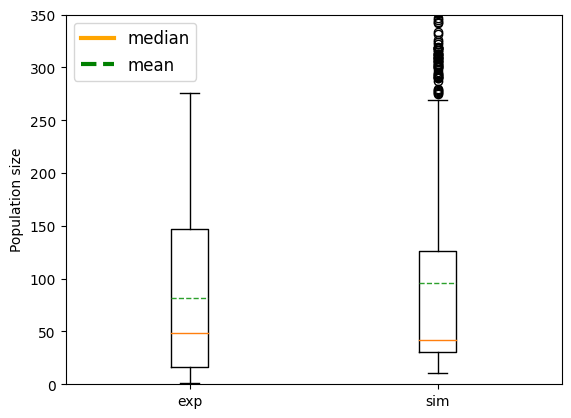

In [78]:
#check if these parameters are able to generate a predictable output
optimum_params_acc_pso_all_four_metapop= [3.64684987, 0.12945676, 0.91398383, 2.58379561]
food = optimum_params_acc_pso_all_four_metapop[0]
sen_adden = optimum_params_acc_pso_all_four_metapop[1]
sen_adsize = optimum_params_acc_pso_all_four_metapop[2]
adnut = optimum_params_acc_pso_all_four_metapop[3]

LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation_all_vars(numegg,food,adnut,numegg,food,adnut,generations,replicates, sen_adden, sen_adsize, 0.45)
simulated_pop_optimum_with_trained_on_first_three_reps = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)


#checking how it fares wth reproducing training set itself - trained on all four test on all four

#boxplot of the population sizes
all_points_list = [migration_45_metapop_nadult_matrix[:,0:3].flatten(),simulated_pop_optimum_with_trained_on_first_three_reps.flatten()]
plt.boxplot(all_points_list,meanline=True,showmeans=True)
plt.ylim(0, 350)
plt.xticks([1, 2], ['exp', 'sim'])
plt.ylabel('Population size')
myHandle = [Line2D([], [], color='orange', lw = 3), Line2D([], [], color='green', linestyle = "dashed", lw = 3)]
plt.legend(handles = myHandle, labels=['median', 'mean'], frameon = True, loc = 'best', fontsize = 12)


In [49]:
#train time series using new cost function - with IQRs and stuff both sub and meta
#do on all four patches - trianing. Then test 15%  (any othr laternate)

#constants - 
generations = 26
replicates = 25
f = 0.45
numegg = 18

#training it on first three metapop replicates

def objective_function(x):
    objective_function_output_array = []
    for k in x:
        food = k[0]
        sen_adden = k[1]
        sen_adsize = k[2]
        adnut = k[3]
        LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation_all_vars(numegg,food,adnut,numegg,food,adnut,generations,replicates, sen_adden, sen_adsize, f)
        LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
        cost = cost_function_new(migration_45_metapop_nadult_matrix, migration_45_nadult_matrix1, migration_45_nadult_matrix2, LHLH_metapop_nadult_matrix, LHLH_numadult_matrix1, LHLH_numadult_matrix2)
        objective_function_output_array.append(cost)
    return objective_function_output_array

options = {'c1': 1.6, 'c2': 1.6, 'w':0.7}
min_bound = [0, 0, 0, 0]
max_bound = [5, 5, 2, 4]
bound_values = (min_bound, max_bound)

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=120, dimensions=4, options = options, bounds= bound_values)
# Perform optimization
best_cost, best_pos = optimizer.optimize(objective_function, iters=150)





2023-12-16 16:32:34,541 - pyswarms.single.global_best - INFO - Optimize for 150 iters with {'c1': 1.6, 'c2': 1.6, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/150

pyswarms.single.global_best: 100%|██████████|150/150, best_cost=0.175
2023-12-16 17:33:59,387 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.17495786400782937, best pos: [2.72030747 0.08998203 0.8557881  1.61678049]


In [ ]:
0.25 trail 1 - [3.08092332 0.10182029 0.8933751  1.8015495 ]